<a href="https://colab.research.google.com/github/cristianmunoz1/DeepLearning-Project/blob/main/04_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arquitectura de Transfer Learning (ResNet50)
Esta segunda iteración se enfoca en aplicar la técnica de Transfer Learning utilizando una arquitectura preentrenada, como ResNet50, para aprovechar el conocimiento extraído de un dataset masivo (ImageNet).

El objetivo principal es establecer una nueva línea base mejorada que supere el rendimiento del modelo CNN simple anterior, abordando directamente las limitaciones de capacidad de aprendizaje y tiempo de entrenamiento.

Se espera un aumento significativo en el F2-Score global, junto con una mejor capacidad para clasificar las clases minoritarias.

### Carga de datos
Se hace uso del mismo proceso para la adquisición de datos desde la API de Kaggle y el preprocesado ya definido


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
import os

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhonatangranda","key":"0f547dc8ab8b2e9acb4f8c16c675367c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nikitarom/planets-dataset
!unzip -q planets-dataset.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/nikitarom/planets-dataset
License(s): DbCL-1.0
 99% 1.49G/1.50G [00:22<00:00, 238MB/s]
100% 1.50G/1.50G [00:22<00:00, 71.3MB/s]


In [ ]:
import os
print(os.listdir("data"))
print("------------")
print(os.listdir("data/planet/planet"))

['planet', 'test-jpg-additional']
------------
['train-jpg', 'sample_submission.csv', 'train_classes.csv', 'test-jpg']


## Importar librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

### Definición de rutas base

En esta etapa se establecen las ubicaciones principales donde residen los datos necesarios para el proceso. En particular, se utiliza `TRAIN_JPG_DIR` como ruta principal en este notebook para acceder a todas las imágenes etiquetadas disponibles. A partir de ese directorio se realiza la partición del dataset, separando muestras para entrenamiento y validación. Aunque las imágenes del conjunto de validación no participan durante el aprendizaje, sí cuentan con etiquetas conocidas, lo que permite evaluar el desempeño del modelo sobre ejemplos nuevos y medir su capacidad de generalización desde el inicio del flujo.

In [ ]:
PROJECT_FOLDER = 'data/planet/planet'
TRAIN_JPG_DIR = os.path.join(PROJECT_FOLDER, 'train-jpg')
TRAIN_CSV_PATH = os.path.join(PROJECT_FOLDER, 'train_classes.csv')

# Hiperparámetros
IMG_SIZE = (128, 128) # (224, 224) para ResNet50
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.0001

# Configuración
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Épocas: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Tamaño de imagen: (128, 128)
Batch size: 64
Épocas: 5
Learning rate: 0.0001


In [ ]:
# Cargar CSV
train_df = pd.read_csv(TRAIN_CSV_PATH)

# Convertir etiquetas a formato binario
dummies = train_df['tags'].str.get_dummies(' ')
labels = dummies.columns.values
N_LABELS = len(labels)
train_df = pd.concat([train_df, dummies], axis=1)

# Dividir en train y validation
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

print(f"Train: {len(train_data)} imágenes")
print(f"Validation: {len(val_data)} imágenes")
print(f"Número de clases: {N_LABELS}")

Train: 32383 imágenes
Validation: 8096 imágenes
Número de clases: 17


## Definición de funciones de preprocesado
En este apartado se declaran las funciones encargadas de transformar las imágenes antes de ingresarlas al modelo. Usamos la misma algoritmica operativa que en el notebook anterior para entregarle al modelo, la data preprocesada de la misma manera

In [ ]:
def load_and_preprocess_image(img_name, img_size=IMG_SIZE):
    """
    Carga una imagen, la redimensiona y normaliza.
    """
    img_path = os.path.join(TRAIN_JPG_DIR, f"{img_name}.jpg")
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0 # Normalizar a [0, 1]
    return img_array

def data_generator(dataframe, batch_size=32, img_size=IMG_SIZE, shuffle=True):
    """
    Generador que carga imágenes en lotes.
    """
    n_samples = len(dataframe)
    indices = np.arange(n_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]
            batch_images = []
            batch_labels = []
            for idx in batch_indices:
                row = dataframe.iloc[idx]
                img = load_and_preprocess_image(row['image_name'], img_size)
                label = row[labels].values.astype('float32')
                batch_images.append(img)
                batch_labels.append(label)
            yield np.array(batch_images), np.array(batch_labels)

In [ ]:
steps_per_epoch_train = len(train_data) // BATCH_SIZE
steps_per_epoch_val = len(val_data) // BATCH_SIZE

train_generator = data_generator(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_generator = data_generator(val_data, batch_size=BATCH_SIZE, shuffle=False)

print(f" Steps por época (train): {steps_per_epoch_train}")
print(f" Steps por época (val): {steps_per_epoch_val}")

 Steps por época (train): 505
 Steps por época (val): 126


## Construcción de la arquitectura
Para esta arquitectura se adopta el enfoque de Transfer Learning utilizando ResNet50 como modelo base. El objetivo es aprovechar los vastos conocimientos de extracción de características que ResNet50 aprendió en el dataset de ImageNet.

Primeramente se toma el modelo base congelado, se carga el modelo ResNet50, una red convolucional profunda y probada, preentrenada con pesos de ImageNet. Se configura con la opción `include_top=False` para excluir la capa de clasificación original de 1000 clases.

Las capas convolucionales de este modelo base se congelan `(layer.trainable = False)`. Esto asegura que, durante la fase inicial de entrenamiento, la robusta capacidad de extracción de características del ResNet50 se mantenga intacta, y el entrenamiento se centre únicamente en las nuevas capas de clasificación añadidas.


### Salida del modelo
Sobre la salida del modelo base congelado, se construye una nueva "cabeza" de clasificación adaptada a la tarea multi-etiqueta(17 labels):

`GlobalAveragePooling2D`: Esta capa se utiliza para reducir drásticamente las dimensiones espaciales de la salida convolucional, resumiendo la información de cada mapa de características en un único valor promedio. Esto actúa como un paso eficiente para aplanar la salida sin perder información espacial crucial.

`Capa Densa (256 neuronas)`: Actúa como clasificador intermedio con activación `ReLU`, aprendiendo a mapear las características resumidas por ResNet50 a las etiquetas específicas de las imágenes satelitales.

`Dropout (0.5)`: Se aplica para regularización, desactivando el 50% de las neuronas aleatoriamente para evitar el sobreajuste.

`Capa de Salida`: Contiene el número exacto de clases (num_classes = 17) y utiliza la activación Sigmoid. Esta activación es esencial para la clasificación multi-etiqueta, ya que permite que el modelo asigne una probabilidad de forma independiente a cada una de las 17 clases.

El resultado entonces es un modelo que combina la eficiencia y robustez del modelo ResNet50 preentrenado con un clasificador simple y específico (que se adapta a la tarea particular).

In [ ]:
def build_transfer_model(input_shape=(128, 128, 3), num_classes=17):
    """
    Define un modelo de Transfer Learning utilizando ResNet50
    preentrenado, congelando las capas base.
    """
    # 1. Cargar el modelo base preentrenado (ResNet50)
    base_model = ResNet50(weights='imagenet', # Usar pesos preentrenados
                          include_top=False,  # Excluir la capa de clasificación superior
                          input_shape=input_shape)

    # 2. Congelar las capas convolucionales del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Construir la cabeza de clasificación (clasificador)
    x = base_model.output
    # Usar GlobalAveragePooling para reducir las dimensiones
    x = GlobalAveragePooling2D()(x)
    # Capas densas para la clasificación multi-etiqueta
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Capa de salida con activación 'sigmoid' para clasificación multi-etiqueta
    predictions = Dense(num_classes, activation='sigmoid')(x)

    # 4. Crear el modelo completo
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

model = build_transfer_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=N_LABELS)

# Arquitectura
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,116,625 (92.00 MB)

 Trainable params: 528,913 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Proceso de Compilación
A continuación realizamos el compile para ver los elementos que estaran presentes en el proceso de calibración. Se utiliza el optimizador Adam, adecuado para ajustarse dinámicamente a los gradientes y facilitar una convergencia estable. La función de pérdida seleccionada es binary_crossentropy, apropiada para problemas de clasificación multietiqueta, ya que evalúa cada clase de forma independiente. Además, se incorporan métricas complementarias como accuracy, precision y recall, que permiten analizar el desempeño desde distintas perspectivas. Finalmente, se agrega el F2-score como métrica principal, debido a que otorga mayor peso al recall, lo cual es especialmente útil cuando interesa reducir falsos negativos y asegurar que el modelo identifique la mayor cantidad posible de etiquetas presentes en una imagen.

In [ ]:
from tensorflow.keras.metrics import FBetaScore

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             FBetaScore(beta=2.0, threshold=0.5, name='f2_score')]
)

print(" Optimizer: Adam")
print(" Loss: binary_crossentropy")
print(" Metrics: accuracy, precision, recall, f2_score")

 Optimizer: Adam
 Loss: binary_crossentropy
 Metrics: accuracy, precision, recall, f2_score


## Configuración de Callbacks

Se definen callbacks con el fin de supervisar y optimizar el proceso de entrenamiento. El primero es `ModelCheckpoint`, encargado de guardar automáticamente el modelo únicamente cuando obtiene el mejor desempeño en el conjunto de validación, evaluado mediante la menor `val_loss`. Esto evita conservar versiones sobreajustadas y garantiza disponer del modelo más estable. Adicionalmente, se define `EarlyStopping`, pero inicialmente no se usa, el propósito es detener el entrenamiento cuando la pérdida de validación deja de mejorar después de cierto número de épocas, evitando así un sobreentrenamiento innecesario. Al activar `restore_best_weights`, el modelo recupera los parámetros correspondientes al mejor punto del entrenamiento. Ambos mecanismos contribuyen a eficiencia computacional y mejor generalización.

In [ ]:
# Guardar el mejor modelo
checkpoint = ModelCheckpoint(
    'modelo_transfer_best.h5', #
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, early_stop]

In [ ]:
# proceso de entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0692 - f2_score: 0.1720 - loss: 0.4505 - precision: 0.4652 - recall: 0.5485
Epoch 1: val_loss improved from inf to 0.25641, saving model to modelo_transfer_best.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 2786s 5s/step - accuracy: 0.0692 - f2_score: 0.1720 - loss: 0.4503 - precision: 0.4654 - recall: 0.5485 - val_accuracy: 0.0000e+00 - val_f2_score: 0.1123 - val_loss: 0.2564 - val_precision: 0.8176 - val_recall: 0.5722
Epoch 2/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0259 - f2_score: 0.1173 - loss: 0.2802 - precision: 0.7887 - recall: 0.5540
Epoch 2: val_loss improved from 0.25641 to 0.25468, saving model to modelo_transfer_best.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 2722s 5s/step - accuracy: 0.0259 - f2_score: 0.1173 - loss: 0.2802 - precision: 0.7888 - recall: 0.5540 - val_accuracy: 0.0000e+00 - val_f2_score: 0.1123 - val_loss: 0.2547 - val_precision: 0.8180 - val_recall: 0.5719
Epoch 3/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0076 - f2_score: 0.1134 - loss: 0.2731 - precision: 0.8030 - recall: 0.5532
Epoch 3: val_loss improved from 0.25468 to 0.25344, saving model to modelo_transfer_best.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 2722s 5s/step - accuracy: 0.0076 - f2_score: 0.1134 - loss: 0.2731 - precision: 0.8030 - recall: 0.5532 - val_accuracy: 0.0000e+00 - val_f2_score: 0.1123 - val_loss: 0.2534 - val_precision: 0.8178 - val_recall: 0.5721
Epoch 4/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0025 - f2_score: 0.1124 - loss: 0.2670 - precision: 0.8117 - recall: 0.5597
Epoch 4: val_loss improved from 0.25344 to 0.25312, saving model to modelo_transfer_best.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 2696s 5s/step - accuracy: 0.0025 - f2_score: 0.1124 - loss: 0.2670 - precision: 0.8117 - recall: 0.5597 - val_accuracy: 0.0000e+00 - val_f2_score: 0.1122 - val_loss: 0.2531 - val_precision: 0.8172 - val_recall: 0.5716
Epoch 5/5
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 3.3435e-04 - f2_score: 0.1122 - loss: 0.2630 - precision: 0.8154 - recall: 0.5663
Epoch 5: val_loss improved from 0.25312 to 0.25217, saving model to modelo_transfer_best.h5


505/505 ━━━━━━━━━━━━━━━━━━━━ 2685s 5s/step - accuracy: 3.3424e-04 - f2_score: 0.1122 - loss: 0.2630 - precision: 0.8154 - recall: 0.5663 - val_accuracy: 0.0000e+00 - val_f2_score: 0.1123 - val_loss: 0.2522 - val_precision: 0.8179 - val_recall: 0.5725
Restoring model weights from the end of the best epoch: 5.


## Curvas de aprendizaje


En esta sección se recuperan las métricas registradas durante el entrenamiento `[precisión, recall, accuracy y pérdida]` tanto para el conjunto de entrenamiento como para el de validación. Dado que algunas versiones de Keras no devuelven directamente el F2-Score por época, surge la necesiadad de realizar el cálculo manual a partir de precisión y recall, aplicando la fórmula correspondiente. Esto permite disponer de una métrica adicional alineada con el objetivo del problema, especialmente útil en escenarios donde es más importante detectar correctamente las clases presentes que evitar falsos positivos.


Partiendo de la forma general de la metrica F score, obtenemos que:

$$
F_{2} = \frac{5 \cdot \text{Precision} \cdot \text{Recall}}{4 \cdot \text{Precision} + \text{Recall}}
$$


### Análisis visual del entrenamiento y cálculo del F2-Score
Posteriormente, se generan múltiples gráficos comparativos que muestran cómo evolucionan las métricas a lo largo de las épocas. Esta visualización facilita identificar comportamientos relevantes como mejora progresiva, estancamiento, posibles señales de sobreajuste o diferencias entre entrenamiento y validación. Finalmente, se reporta el F2-Score obtenido en la última época de validación, empleándolo como referencia para evaluar el desempeño global del modelo.

Train F2 por época: [0.56150911 0.58670554 0.59308025 0.59793446 0.6002473 ]
Val F2 por época: [0.60877313 0.60850952 0.60864531 0.608182   0.60905402]


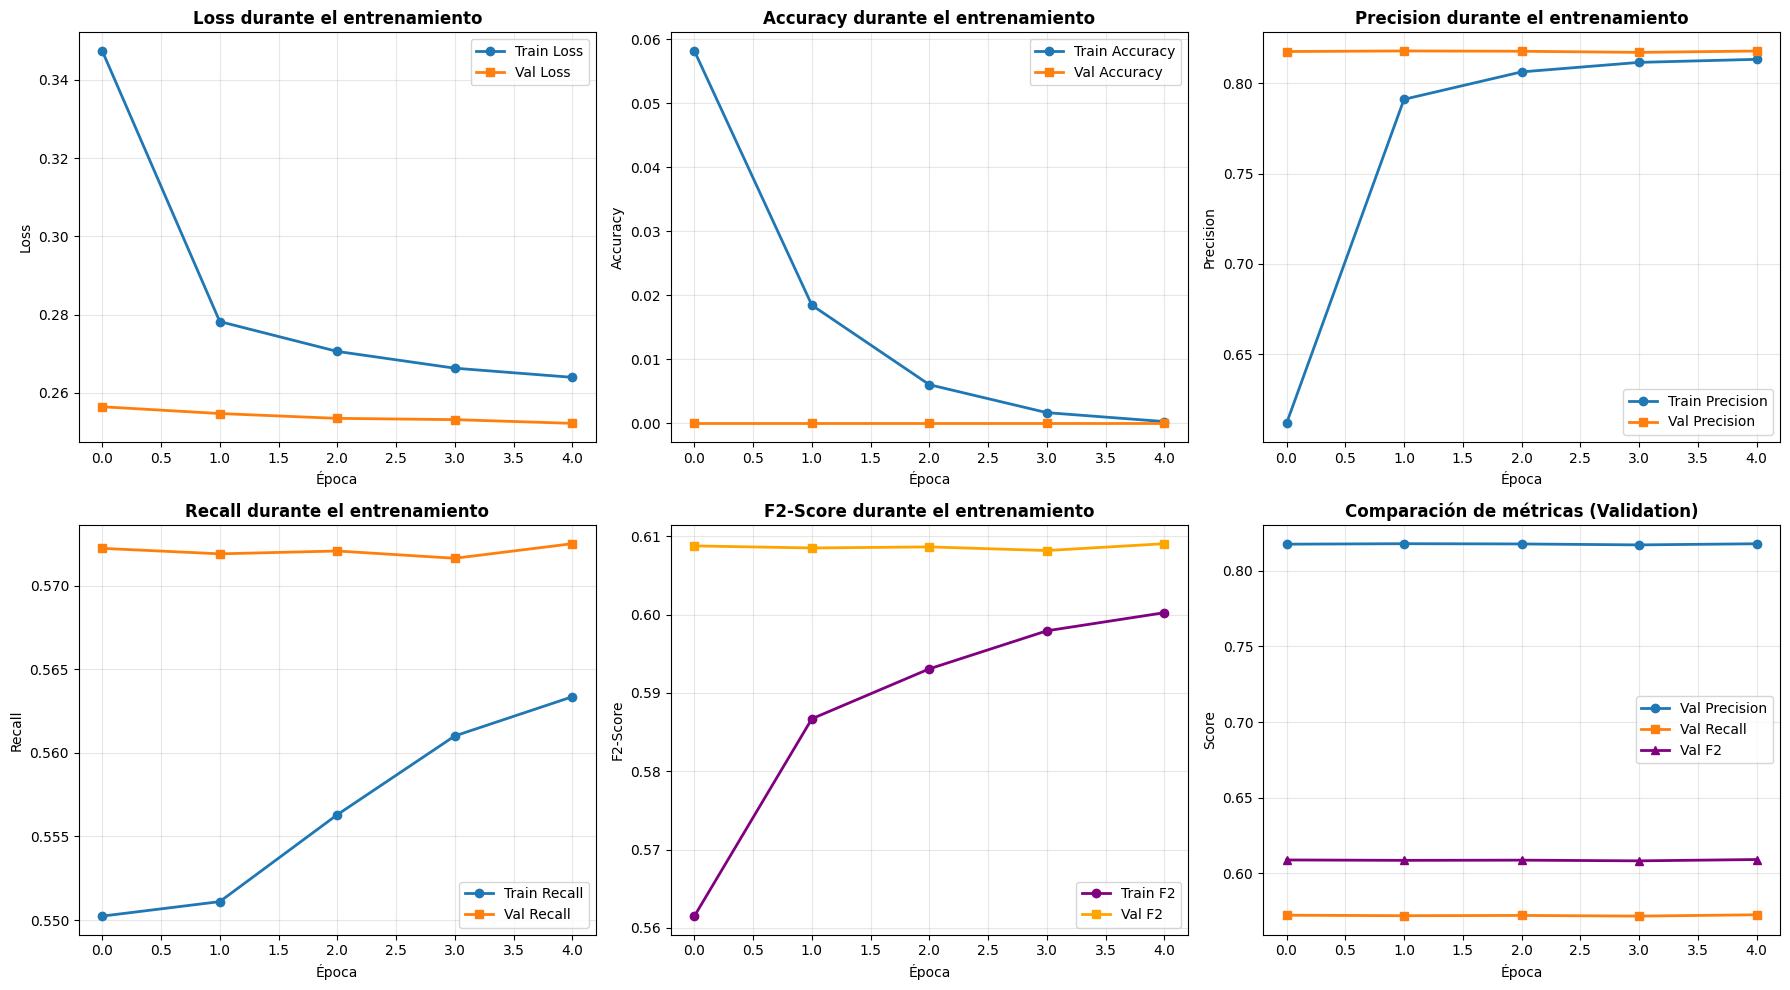

F2-Score final (validation): 0.6091


In [ ]:
import numpy as np
# Extraer precision y recall del history
train_precision = np.array(history.history['precision'])
train_recall = np.array(history.history['recall'])
val_precision = np.array(history.history['val_precision'])
val_recall = np.array(history.history['val_recall'])

# Calcular F2 manualmente
def calculate_f2(precision, recall):
    """Calcula F2-Score desde precision y recall, solucionar problema de array de valores"""
    # Evitar división por cero
    denominator = 4 * precision + recall
    denominator[denominator == 0] = 1e-7  # Pequeño valor para evitar división por cero
    return (5 * precision * recall) / denominator

train_f2 = calculate_f2(train_precision, train_recall)
val_f2 = calculate_f2(val_precision, val_recall)

# Calculo del F2 promedio -- Calculo micro
print(f"Train F2 por época: {train_f2}")
print(f"Val F2 por época: {val_f2}")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_title('Loss durante el entrenamiento', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
axes[0, 1].set_title('Accuracy durante el entrenamiento', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[0, 2].plot(train_precision, label='Train Precision', marker='o', linewidth=2)
axes[0, 2].plot(val_precision, label='Val Precision', marker='s', linewidth=2)
axes[0, 2].set_title('Precision durante el entrenamiento', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Época')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Recall
axes[1, 0].plot(train_recall, label='Train Recall', marker='o', linewidth=2)
axes[1, 0].plot(val_recall, label='Val Recall', marker='s', linewidth=2)
axes[1, 0].set_title('Recall durante el entrenamiento', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# F2-Score (calculado manualmente)
axes[1, 1].plot(train_f2, label='Train F2', marker='o', color='purple', linewidth=2)
axes[1, 1].plot(val_f2, label='Val F2', marker='s', color='orange', linewidth=2)
axes[1, 1].set_title('F2-Score durante el entrenamiento', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('F2-Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Comparación de métricas
axes[1, 2].plot(val_precision, label='Val Precision', marker='o', linewidth=2)
axes[1, 2].plot(val_recall, label='Val Recall', marker='s', linewidth=2)
axes[1, 2].plot(val_f2, label='Val F2', marker='^', color='purple', linewidth=2)
axes[1, 2].set_title('Comparación de métricas (Validation)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Época')
axes[1, 2].set_ylabel('Score')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"F2-Score final (validation): {val_f2[-1]:.4f}")

## Conclusiones sobre el entrenamiento

* El loss de entrenamiento disminuye de forma consistente, lo que indica que el modelo sigue aprendiendo durante las épocas.

* El loss de validación se mantiene estable y ligeramente decreciente, sin señales fuertes de sobreajuste. El comportamiento es uniforme, lo cual indica que el modelo generaliza de forma adecuada.

* La accuracy en validación es prácticamente nula, lo cual es normal en problemas multietiqueta y confirma que esta métrica no es representativa en este tipo de tareas.

* La precision en validación se mantiene alta y estable (≈ 0.81–0.82), lo que evidencia que el modelo mantiene una baja tasa de falsos positivos. El modelo es conservador al activar etiquetas.

* El recall en validación se mantiene bajo y prácticamente plano (≈ 0.572–0.573), mostrando que el modelo sigue dejando etiquetas verdaderas sin detectar.

* El F2-score en validación presenta una ligera tendencia a la baja, iniciando alrededor de 0.609 y terminando aproximadamente en 0.6091, lo que refleja:

  * estabilidad del modelo,

  * pero también estancamiento en su capacidad para mejorar recall,

  * y un leve deterioro del balance entre sensibilidad y precisión.


El modelo basado en ResNet con transfer learning aprende de forma estable y generaliza razonablemente bien, manteniendo métricas estables en validación. Sin embargo:

* El recall sigue siendo la métrica más débil,

* y el F2-score no mejora, sino que muestra una ligera disminución,
lo que indica que el modelo no está incrementando su capacidad de detectar etiquetas verdaderas.

In [ ]:
val_gen_eval = data_generator(val_data, batch_size=BATCH_SIZE, shuffle=False)
results = model.evaluate(val_gen_eval, steps=steps_per_epoch_val, verbose=1)

# print(f" Val Loss: {results[0]:.4f}")
print(f" Val Accuracy: {results[1]:.4f}")
print(f" Val Precision: {results[2]:.4f}")
print(f" Val Recall: {results[3]:.4f}")

# Calcular F2
val_f2_calculated = (5 * results[2] * results[3]) / (4 * results[2] + results[3])
print(f"Val F2-Score : {val_f2_calculated:.4f}")

## Comportamiento de las predicciones
En esta sección se analiza cualitativamente el desempeño del modelo, visualizando cómo clasifica imágenes del conjunto de validación. Para ello, se selecciona una muestra aleatoria de imágenes que no participaron en el entrenamiento pero cuentan con etiquetas reales, lo que permite comparar directamente la predicción del modelo con la verdad de referencia.

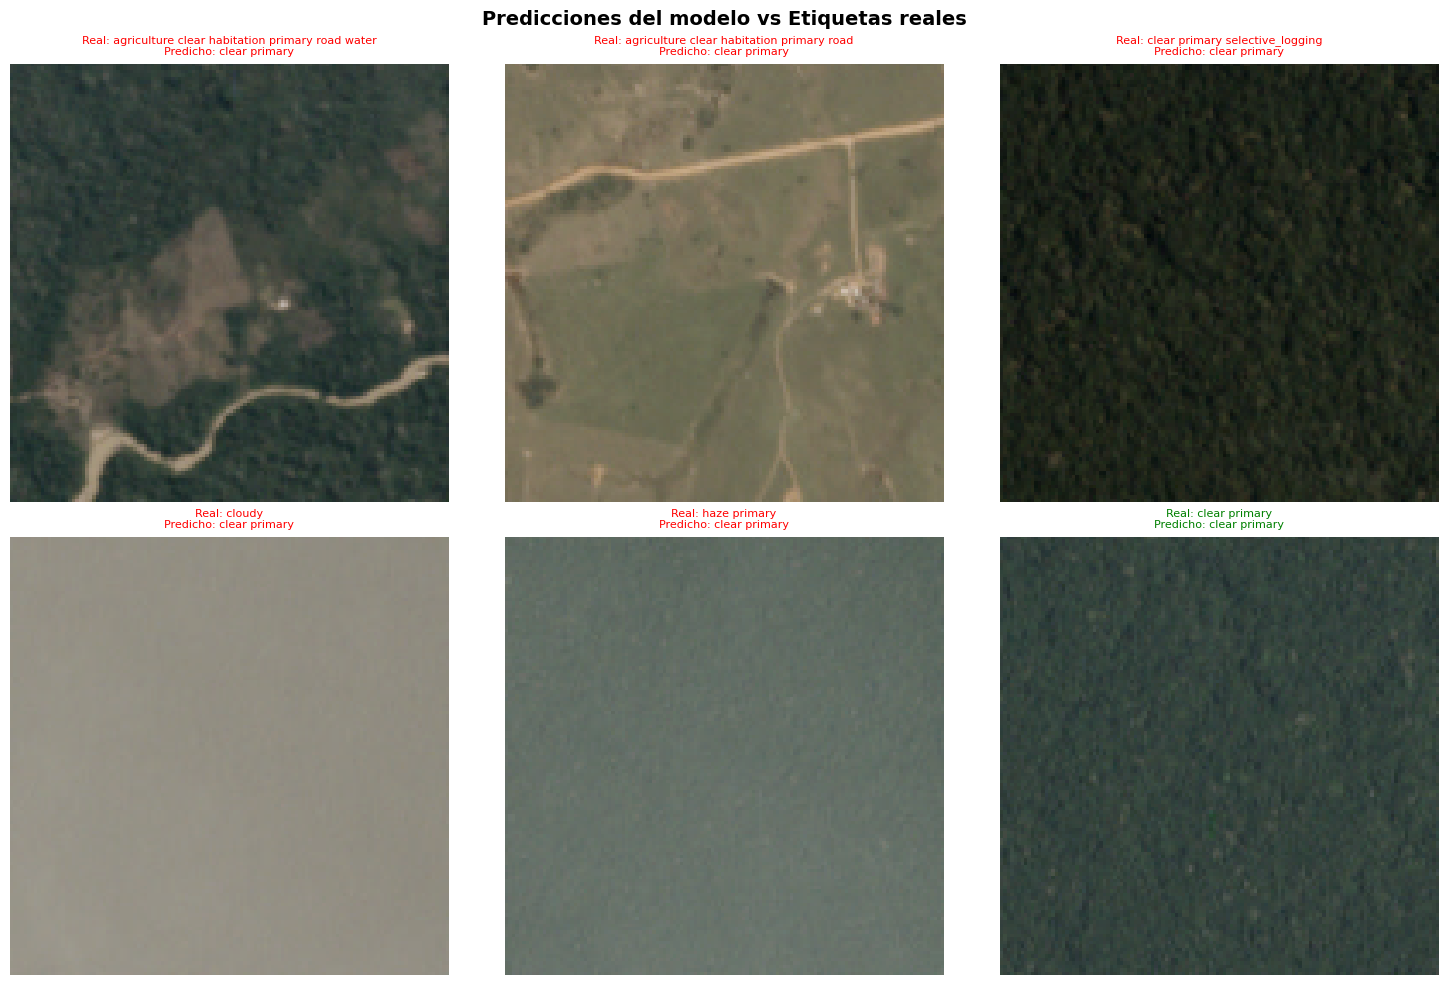

In [ ]:
sample_val = val_data.sample(6, random_state=42)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Predicciones del modelo vs Etiquetas reales', fontsize=14, fontweight='bold')

for i, row in enumerate(sample_val.itertuples()):
    # Cargar imagen
    img = load_and_preprocess_image(row.image_name)
    img_batch = np.expand_dims(img, axis=0)

    # Predecir
    predictions = model.predict(img_batch, verbose=0)[0]

    # Obtener etiquetas predichas (umbral 0.5)
    predicted_labels = [labels[j] for j, pred in enumerate(predictions) if pred > 0.5]

    # Etiquetas reales
    real_labels = row.tags.split()

    # Visualizar
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

    title = f"Real: {' '.join(real_labels)}\nPredicho: {' '.join(predicted_labels) if predicted_labels else 'ninguna'}"
    ax.set_title(title, fontsize=8, color='green' if set(predicted_labels) == set(real_labels) else 'red')

plt.tight_layout()
plt.show()

### Rendimiento por clase
Luego de obtener predicciones para todo el conjunto de validación, se realiza un análisis detallado por etiqueta con el objetivo de evaluar cómo se comporta el modelo individualmente en cada clase. Para ello, las probabilidades generadas por el modelo se convierten en salidas binarias mediante un umbral de decisión de 0.5, indicando si una clase está presente o no en cada imagen.

In [ ]:
# Hacer predicciones en todo el conjunto de validación
all_predictions = []
all_true_labels = []

val_gen_predict = data_generator(val_data, batch_size=BATCH_SIZE, shuffle=False)

for i in range(steps_per_epoch_val):
    X_batch, y_batch = next(val_gen_predict)
    preds = model.predict(X_batch, verbose=0)
    all_predictions.extend(preds)
    all_true_labels.extend(y_batch)

all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Aplicar umbral
predicted_binary = (all_predictions > 0.5).astype(int)

# Calcular métricas por clase
from sklearn.metrics import precision_score, recall_score, fbeta_score

class_metrics = []
for i, label in enumerate(labels):
    precision = precision_score(all_true_labels[:, i], predicted_binary[:, i], zero_division=0)
    recall = recall_score(all_true_labels[:, i], predicted_binary[:, i], zero_division=0)
    f2 = fbeta_score(all_true_labels[:, i], predicted_binary[:, i], beta=2, zero_division=0)
    support = all_true_labels[:, i].sum()

    class_metrics.append({
        'Clase': label,
        'Precision': precision,
        'Recall': recall,
        'F2-Score': f2,
        'Support': int(support)
    })

metrics_df = pd.DataFrame(class_metrics)
metrics_df = metrics_df.sort_values('F2-Score', ascending=False)
print(metrics_df.to_string(index=False))

            Clase  Precision  Recall  F2-Score  Support
          primary   0.927455     1.0  0.984597     7479
            clear   0.707837     1.0  0.923744     5708
      agriculture   0.000000     0.0  0.000000     2428
         blooming   0.000000     0.0  0.000000       64
   artisinal_mine   0.000000     0.0  0.000000       70
        blow_down   0.000000     0.0  0.000000       24
           cloudy   0.000000     0.0  0.000000      391
conventional_mine   0.000000     0.0  0.000000       22
      bare_ground   0.000000     0.0  0.000000      173
      cultivation   0.000000     0.0  0.000000      861
       habitation   0.000000     0.0  0.000000      740
             haze   0.000000     0.0  0.000000      531
    partly_cloudy   0.000000     0.0  0.000000     1434
             road   0.000000     0.0  0.000000     1558
selective_logging   0.000000     0.0  0.000000       61
       slash_burn   0.000000     0.0  0.000000       47
            water   0.000000     0.0  0.000000  

El modelo con transfer learning muestra un comportamiento extremadamente polarizado. Por un lado, las clases primary y clear alcanzan un rendimiento sobresaliente: ambas presentan un recall perfecto (1.0), y su F2-score es muy alto, especialmente en primary, que llega a 0.98. Esto indica que el modelo, apoyado en las representaciones aprendidas previamente, captura de forma muy efectiva las características de estas clases predominantes y las predice prácticamente sin fallos. Sin embargo, este éxito está concentrado exclusivamente en esas dos clases.

Para el resto de las 15 clases, el resultado es crítico: la precisión, el recall y el F2-score son exactamente cero. Esto indica que el modelo no predice ninguna instancia positiva para ninguna de esas clases, incluso aquellas de presencia media como agriculture, cultivation, road o water, y tampoco para las clases raras. Lo anterior sugiere que el modelo ha colapsado su comportamiento hacia una estrategia altamente conservadora, en la que prácticamente decide que solo existen dos clases relevantes en el dataset. El transfer learning no logró aportar generalización a las demás categorías; por el contrario, parece haber reforzado un sesgo aún mayor hacia las clases dominantes.

Este fenómeno puede deberse a varios factores: el desbalance severo del dataset, el umbral fijo de clasificación, la desadaptación entre las características aprendidas del modelo preentrenado y la naturaleza multietiqueta del problema, o incluso a un entrenamiento demasiado corto que no permitió ajustar adecuadamente las capas superiores. En cualquiera de los casos, el modelo demuestra que, pese al uso de transfer learning, solo generaliza en 2 de las 17 clases, mientras que el resto quedan completamente sin aprender.

En conjunto, estos resultados muestran que la incorporación de transfer learning, tal como se implementó aquí, no solo no resolvió las limitaciones del modelo baseline, sino que exacerbó el problema al reducir de manera drástica la diversidad de clases que el modelo es capaz de reconocer.